**Emotion Detection through Facial Recognition**

**Objective:** To successfully evaluate any picture that includes people and indicate the emotional state of the individuals in the picture.

Load Facial Expression Recognition Library developed by Justin Shenk.
https://github.com/justinshenk/fer

In [2]:
!pip install -q fer

     |████████████████████████████████| 812 kB 16.5 MB/s 
     |████████████████████████████████| 2.3 MB 53.0 MB/s 


In [3]:
import cv2
from fer import FER
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Read emotions by evalualating of the individaul facial image and using the FER API to detect emotions.  This version of the FER dataset is only evaluating 7 emotions:
1) Angry
2) Disgust
3) Fear
4) Happy
5) Neutral
6) Sad
7) Surprise

The result is a dictionary containing percentage in terms of a score:

'emotions': {
  'angry': 0.02, 'disgust': 0.0, 'fear': 0.05,
  'happy': 0.16, 'neutral': 0.09, 'sad': 0.27, 'surprise': 0.41}

method **read_emotions** returns the emotion with the top percentage

method **display_top_emotions** uses Haar-cascade dection in OpenCV to detect facial images in picture and writes creates the bounding box and writes the top emotion for each face in the picture


In [4]:
def read_emotions(img):
  """
  Params:
          img: img containing specific face 
  Returns:
          emotion_name: emotion with the top score (percentage)
  """  
  input_image = cv2.imread(img)
  #emotion_detector = FER(mtcnn=True)
  emotion_detector = FER()
  emotion_name =""
  # Output image's information
  print(emotion_detector.detect_emotions(input_image))
  result = emotion_detector.detect_emotions(input_image)
  if (len(result)>0):
    emotion_name, score = emotion_detector.top_emotion(input_image)

  return emotion_name

def display_top_emotions(image):
  """
  Params:
          image: image to evalation with one or more faces to evaluate

  """    
  # ADDED CODE
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
  )
  faces_images = []
  for (x, y, w, h) in faces:
    color = (255, 0,0)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)   
    
    #roi_color = image[y:y + h, x:x + w]
    roi_color = gray[y:y + h, x:x + w]

    print("[INFO] Object found. Saving locally.")
    face_image = str(w) + str(h) + '_faces.jpg'
    cv2.imwrite(str(w) + str(h) + '_faces.jpg', roi_color)

    emotion = read_emotions(face_image)

    print("emotion",emotion)
    cv2.putText(image,emotion, (x, y), cv2.FONT_HERSHEY_SIMPLEX,2,color,3,cv2.LINE_AA,)

    faces_images.append(face_image)
    cv2.imwrite(face_image, roi_color)

    #gray_image = mpimg.imread(face_image)
    #gray_image = cv2.cvtColor(gray_image, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray_image,cmap='gray')
    #plt.show()  

  status = cv2.imwrite('faces_detected.jpg', image)
  print("[INFO] Image faces_detected.jpg written to filesystem: ", status)
  result_image = mpimg.imread('faces_detected.jpg')
  plt.imshow(result_image)
  plt.show()  

**Part 1**

Take Photo using webcam to take photo of user(s) and to retrieve emotion

*Referencing Javasscript code from the assignment 6 in order to allow Google Colab to have access to computer's webcam.*

In [5]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  image = js_to_image(data) 

  display_top_emotions(image)

  return filename

<IPython.core.display.Javascript object>

[INFO] Object found. Saving locally.
[{'box': array([ 11,  15, 156, 156], dtype=int32), 'emotions': {'angry': 0.02, 'disgust': 0.0, 'fear': 0.08, 'happy': 0.02, 'sad': 0.01, 'surprise': 0.87, 'neutral': 0.0}}]
emotion surprise
[INFO] Image faces_detected.jpg written to filesystem:  True


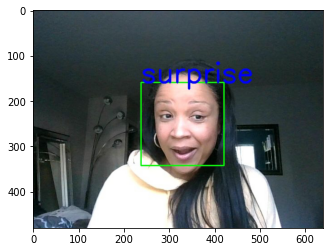

Saved to photo.jpg


In [ ]:
# Now call take_photo() function and save the output to a file
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**Part 2**

Use file upload option to load image from local computer and to detect emotion details of faces in image

Saving 2022-11-22_8-03-42.png to 2022-11-22_8-03-42.png
[INFO] Object found. Saving locally.
[{'box': array([ 5,  5, 67, 67], dtype=int32), 'emotions': {'angry': 0.19, 'disgust': 0.0, 'fear': 0.03, 'happy': 0.25, 'sad': 0.02, 'surprise': 0.01, 'neutral': 0.5}}]
emotion neutral
[INFO] Object found. Saving locally.
[{'box': array([ 6,  8, 85, 85], dtype=int32), 'emotions': {'angry': 0.88, 'disgust': 0.08, 'fear': 0.01, 'happy': 0.0, 'sad': 0.02, 'surprise': 0.0, 'neutral': 0.02}}]
emotion angry
[INFO] Object found. Saving locally.
[]
emotion 
[INFO] Object found. Saving locally.
[{'box': array([ 9, 24, 90, 90], dtype=int32), 'emotions': {'angry': 0.1, 'disgust': 0.0, 'fear': 0.33, 'happy': 0.33, 'sad': 0.02, 'surprise': 0.18, 'neutral': 0.03}}]
emotion fear
[INFO] Object found. Saving locally.
[{'box': array([ 1,  2, 54, 54], dtype=int32), 'emotions': {'angry': 0.23, 'disgust': 0.0, 'fear': 0.16, 'happy': 0.0, 'sad': 0.53, 'surprise': 0.01, 'neutral': 0.07}}]
emotion sad
[INFO] Object fo

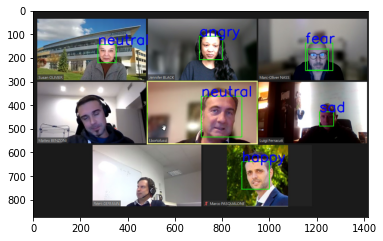

In [6]:
from google.colab import files

try:
  uploaded  = files.upload()
  # Show the image which was just taken.
  filename = list(uploaded .keys())[0]
  display_top_emotions(cv2.imread(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [14]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

def read_emotions(img):
  """
  Params:
          img: img containing specific face 
  Returns:
          emotion_name: emotion with the top score (percentage)
  """  
  emotion_dict = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
  input_image = cv2.imread(img)
  # dimensions of our images
  img_width, img_height = 320, 240
  # load the model we saved
  #model = '/content/drive/MyDrive/AAI521_Weights/MobileNet-Classification-7emotions-CNN.h5'
  model = '/content/drive/MyDrive/AAI521_Weights/FER_VGG16_v01.h5'
  emotion_detector = load_model(model)
  emotion_detector.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

  input_image = np.expand_dims(np.expand_dims(cv2.resize(input_image,(48,48)),-1),0)
  #input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
  emotion_name =""
  # Output image's information
  print(emotion_detector.predict(input_image))
  prediction = emotion_detector.predict(input_image)
  maxIndex = int(np.argmax(prediction))
  topEmotion = emotion_dict[maxIndex]
  print(maxIndex)
  #if (len(result)>0):
  #  emotion_name, score = emotion_detector.top_emotion(input_image)

  return topEmotion


<IPython.core.display.Javascript object>

[INFO] Object found. Saving locally.
1/1 [==============================] - 0s 201ms/step
[[0. 0. 0. 0. 0. 1. 0.]]
1/1 [==============================] - 0s 69ms/step
5
emotion Surprise
[INFO] Image faces_detected.jpg written to filesystem:  True


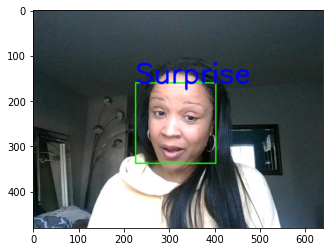

In [ ]:
# Now call take_photo() function and save the output to a file

try:
 
    filename = take_photo('photo.jpg')


except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Saving 2022-11-22_8-03-42.png to 2022-11-22_8-03-42 (4).png
[INFO] Object found. Saving locally.
1/1 [==============================] - 0s 178ms/step
[[0. 0. 0. 0. 0. 0. 1.]]
1/1 [==============================] - 0s 47ms/step
6
emotion Neutral
[INFO] Object found. Saving locally.
1/1 [==============================] - 0s 167ms/step
[[0. 0. 0. 1. 0. 0. 0.]]
1/1 [==============================] - 0s 43ms/step
3
emotion Happy
[INFO] Object found. Saving locally.
1/1 [==============================] - 0s 169ms/step
[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.000000e+00 6.374057e-33]]
1/1 [==============================] - 0s 43ms/step
5
emotion Surprise
[INFO] Object found. Saving locally.
1/1 [==============================] - 0s 164ms/step
[[0. 0. 0. 0. 0. 1. 0.]]
1/1 [==============================] - 0s 40ms/step
5
emotion Surprise
[INFO] Object found. Saving locally.
1/1 [==============================] - 0s 175ms/step
[[0.         0.         0.99866164 0. 

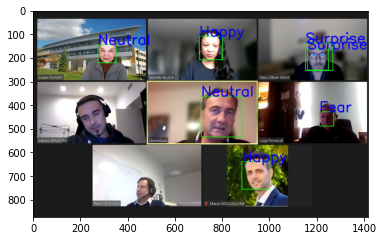

In [15]:
from google.colab import files

try:
  uploaded  = files.upload()
  # Show the image which was just taken.
  filename = list(uploaded .keys())[0]
  display_top_emotions(cv2.imread(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
